# SAT Scores vs Demographic Factors in NY City Schools
Goal of this project is to determinine demographic factors that correlate with SAT score. 

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit. The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the dataset for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality. One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. The goal of this project is to investigate the correlations between SAT scores and demographic factors like race, gender, income, and more. 

Data Sources:
- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school. [Data dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) tells us what each column represents.

All of these datasets are interrelated. We'll need to combine them into a single dataset before we can find correlations.

Key points about the data:
- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contain dozens of schools.
- Our datasets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN or district borough number.
- Aggregating data by district allows us to use the district mapping data to plot district-by-district differences.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Reading in the Data

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for file in data_files:
    df = pd.read_csv(f'data/{file}')
    key = file.split(".")[0]
    data[key] = df

### Exploring the Data

In [3]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on this output:

- The DBN appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

In [4]:
for k,v in data.items():
    print(v.head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

We can make some observations based on the first few rows of each one.

- Each dataset appears to either have a DBN column or the information we need to create one. That means we can use a DBN column to combine the datasets. First we'll pinpoint matching rows from different datasets by looking for identical DBNs, then group all of their columns together in a single dataset.
- Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.
- Some of the datasets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each dataset. If we don't do this, we'll run into problems when we combine the datasets, because we might be merging two rows in one data set with one row in another dataset.


### Reading in the Survey Data

Next, let's read in the survey data (survey_all.txt and survey_d75.txt). The files are tab delimited and encoded with Windows-1252 encoding.

In [5]:
all_survey = pd.read_csv('data/survey_all.txt', encoding="windows-1252", sep='\t')
d75_survey = pd.read_csv('data/survey_d75.txt', encoding="windows-1252", sep='\t')

survey = pd.concat([all_survey, d75_survey])
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are two immediate facts that we can see in the data:

- There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns makes it easier to print the dataframe out and find correlations within it.
- The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion makes the column name consistent with the other data sets.

Based on the [dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8), it looks like these are the relevant columns:
["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

These columns give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It also gives us the DBN, which allows us to uniquely identify the school.



In [6]:
survey = survey.copy()
survey['DBN'] = survey['dbn']
cols = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

survey = survey.loc[:,cols]
data['survey'] = survey

### Inserting DBN Fields

When we explored all of the datasets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column, though, so we can just rename it. However, class_size doesn't appear to have the column at all. Here are the first few rows of the data set:

In [7]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


Here are the first few rows of the sat_results data, which does have a DBN column:

In [8]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


From looking at these rows, we can tell that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long. 

Now, let's insert the DBN fields.

In [9]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

data['class_size']['padded_csd'] = data['class_size']['CSD'].astype(str).str.zfill(2)
#print(data['class_size']['padded_csd'])
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


### Combining the SAT Scores

Let's calculate variables that are useful in our analysis. We need a column that totals up the SAT scores for the different sections of the exam. This makes it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones. We will be combining SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns in the sat_results.

In [10]:
sat_cols = [col for col in data['sat_results'] if 'Score' in col]
data['sat_results'][sat_cols] = data['sat_results'][sat_cols].apply(pd.to_numeric,errors='coerce')
#print(data['sat_results'][sat_cols].dtypes)

data['sat_results']['sat_score'] = data['sat_results'][sat_cols].sum(axis=1)
data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

### Parsing Geographic Coordinates for Schools

Next, we'll want to parse the latitude and longitude coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory dataset.

Let's take a look at the first few rows:

In [11]:
from pandas import option_context
with option_context('display.max_colwidth', None):
    print(data['hs_directory']['Location 1'].head())

0        883 Classon Avenue\nBrooklyn, NY 11225\n(40.67029890700047, -73.96164787599963)
1              1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)
2          1501 Jerome Avenue\nBronx, NY 10452\n(40.842414068000494, -73.91616158599965)
3          411 Pearl Street\nNew York, NY 10038\n(40.71067947100045, -74.00080702099967)
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40.718810094000446, -73.80650045499965)
Name: Location 1, dtype: object


This field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field.

In [12]:
#Extracting latitude and longitude from the Location 1 field
#The coordinates are in parentheses at the end of the field.
pattern = r'\(([\d.-]+),'
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].str.extract(pattern, expand=False)
#print(data['hs_directory'].head())

pattern = r'\([\d.-]+,\s+([\d.-]+)\)'
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].str.extract(pattern, expand=False)
data['hs_directory'][['lat','lon']] = data['hs_directory'][['lat','lon']].apply(pd.to_numeric,errors='coerce')
#print(data['hs_directory'][['lat','lon']].dtypes)
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810,-73.806500


### Condensing the Class Size Dataset

The first thing we'll need to do in preparation for the merge is condense some of the datasets. We noticed that the values in the DBN column are unique in the sat_results data set. But other data sets like class_size, graduation and demographics have duplicate DBN values. We'll need to condense these datasets so that each value in the DBN column is unique.

The first dataset that we'll condense is class_size. The first few rows of class_size look like this:

In [13]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


 The first few rows all pertain to the same school, which is why the DBN appears more than once. It looks like each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY).

If we look at the unique values for GRADE, we get the following:

In [14]:
data['class_size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Since we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.

If we look at the unique values for PROGRAM TYPE, we get the following:

In [15]:
data['class_size']['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

In [16]:
data['class_size']['PROGRAM TYPE'].value_counts()

PROGRAM TYPE
GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: count, dtype: int64

Each school can have multiple program types. Since GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.

In [17]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns.

CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) seem to pertain to different kinds of classes. For example, here are the unique values for CORE SUBJECT (MS CORE and 9-12 ONLY):


In [18]:
data['class_size']['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['-', nan, 'ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'],
      dtype=object)

### Computing Average Class Sizes
We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This gives us unique DBN values, while also incorporating as much data as possible into the average.

In [19]:
class_size = class_size.groupby('DBN').mean(numeric_only=True).reset_index()
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1.0,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1.0,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1.0,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1.0,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1.0,57.6000,2.733333,21.200000,19.40,22.866667,NaN


###  Condensing the Demographics Dataset 
Now that we've finished condensing class_size, let's condense demographics. The first few rows look like this:

In [20]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will match our SAT results data.

In [21]:
data["demographics"] = data["demographics"][data["demographics"]['schoolyear'] == 20112012]
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condensing the Graduation Dataset 

Finally, we'll need to condense the graduation dataset. Here are the first few rows:

In [22]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [23]:
data['graduation'] = data['graduation'].query('Cohort == "2006" & Demographic == "Total Cohort"') 
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


### Converting AP Test Scores

We're almost ready to combine all of the datasets. The last thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

In [24]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
data['ap_2010'][cols] = data['ap_2010'][cols].apply(pd.to_numeric, errors='coerce')
print(data['ap_2010'][cols].dtypes)

AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


### Performing the merge

Since this project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from sat_results while minimizing null values.

This means that we may need to use different merge strategies with different datasets. Some of the datasets have a lot of missing DBN values. This makes a left join more appropriate, because we don't want to lose too many rows when we merge. If we did an inner join, we would lose the data for many high schools.

Some datasets have DBN values that are almost identical to those in sat_results. Those datasets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from demographics, for example. Therefore, we'll do an inner join to avoid missing data in these columns.

In [25]:
combined = data["sat_results"]
combined = pd.merge(combined,data['ap_2010'], how='left', on='DBN')
combined = pd.merge(combined,data['graduation'], how='left', on='DBN')

combined = pd.merge(combined,data['class_size'], how='inner', on='DBN')
combined = pd.merge(combined,data['demographics'], how='inner', on='DBN')
combined = pd.merge(combined,data['survey'], how='inner', on='DBN')
combined = pd.merge(combined,data['hs_directory'], how='inner', on='DBN')

print(combined.shape)
combined.head()

(363, 159)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Filling in Missing Values

We now have many columns with null (NaN) values. This is because we chose to do left joins, where some columns may not have had data. The dataset also had some missing values to begin with. If we hadn't performed a left join, all of the rows with missing data would have been lost in the merge process, which wouldn't have left us with many high schools in our data set. 
We can replace the missing values with the means of their respective columns, which allows us to proceed with analyses that can't handle missing values (like correlations).

For columns with mixed or object types, let's ensure the object-type columns are converted to their appropriate inferred data types before filling the missing values with 0.

In [26]:
combined.fillna(combined.mean(numeric_only=True),inplace=True)
combined = combined.infer_objects(copy=False).fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Adding a School District Column for Mapping

We've finished cleaning and combining our data! We now have a clean dataset we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the dataset that specifies the school district helps us accomplish this.

The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [28]:
combined['school_dist'] = combined['DBN'].str[0:2]
print(combined['school_dist'].head())
combined= combined.copy() # avoiding fragmented dataframe by making a copy

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


### Finding Correlations With the r Value

Correlations tell us how closely related two columns are. We'll be using the r value, also called Pearson's correlation coefficient, to measure how closely two sequences of numbers are correlated. A strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. 

In [34]:
pd.options.display.max_rows  = None
correlations = combined.corr(numeric_only=True)
correlations = correlations['sat_score']
print(correlations.sort_values(ascending=False))

sat_score                               1.000000
SAT Writing Avg. Score                  0.472854
SAT Critical Reading Avg. Score         0.472399
SAT Math Avg. Score                     0.465612
SIZE OF LARGEST CLASS                   0.378741
N_s                                     0.347000
N_p                                     0.334171
AVERAGE CLASS SIZE                      0.326426
total_enrollment                        0.308198
female_num                              0.306849
NUMBER OF STUDENTS / SEATS FILLED       0.305352
white_per                               0.302345
asian_num                               0.297773
NUMBER OF SECTIONS                      0.296805
N_t                                     0.294385
total_students                          0.291860
male_num                                0.289770
white_num                               0.279656
asian_per                               0.256366
AP Test Takers                          0.254925
Total Exams Taken   

In general, r values above .25 or below -.25 are enough to qualify a correlation as interesting. An r value isn't perfect and doesn't indicate that there's a correlation, just the possiblity of one. To assess whether a correlation exists, we need to look at the data using a scatterplot.

Based on the r values we obtained, we can make some observations:
- Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score
- total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
- There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
- The percentage of students eligible for free or reduced school lunch based on household income (frl_percent) has a strong negative correlation with SAT scores.
-  English language learners percentage ell_percent has a strong negative correlation with sat_score

### Plotting Enrollment vs SAT Score

Let's explore the relationship between total_enrollment and sat_score further. We'll create a scatterplot to visualize the relationship between these two columns.

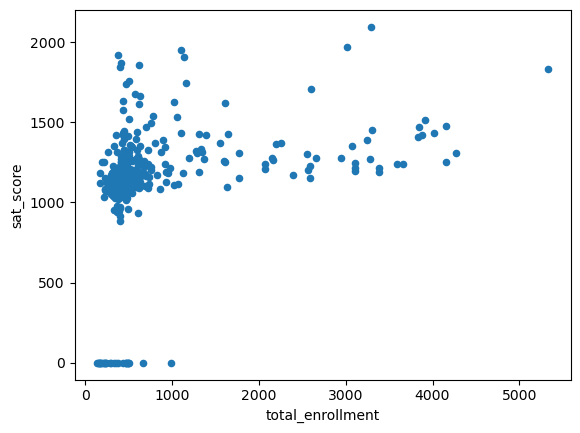

In [35]:
combined.plot.scatter('total_enrollment', 'sat_score')
plt.show()

Judging from the plot we just created, it doesn't appear there's a strong correlation between sat_score and total_enrollment. If there was a strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

### Exploring Schools with Low SAT Scores and Enrollment

In [ ]:
pd.options.display.max_colwidth = None
schools_low_SAT_enrol = combined.query('total_enrollment < 1000 & sat_score < 1000')['SCHOOL NAME']
schools_low_SAT_enrol.unique()


array(['MANHATTAN BUSINESS ACADEMY', 'BUSINESS OF SPORTS SCHOOL',
       'THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY',
       'MANHATTAN ACADEMY FOR ARTS & LANGUAGE',
       'HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES',
       'INTERNATIONAL HIGH SCHOOL AT UNION SQUARE',
       'THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS',
       'THE GLOBAL LEARNING COLLABORATIVE', 'FRANK MCCOURT HIGH SCHOOL',
       'COLUMBIA SECONDARY SCHOOL FOR MATH, SCIENCE, AND ENGINEERING',
       'HIGH SCHOOL FOR EXCELLENCE AND INNOVATION',
       'INTERNATIONAL COMMUNITY HIGH SCHOOL',
       'BRONX STUDIO SCHOOL FOR WRITERS AND ARTISTS',
       'ANTONIA PANTOJA PREPARATORY ACADEMY, A COLLEGE BOARD SCHOOL',
       'BRONX BRIDGES HIGH SCHOOL',
       'BRONX EARLY COLLEGE ACADEMY FOR TEACHING & LEARNING',
       'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
       'BRONX INTERNATIONAL HIGH SCHOOL',
       'KINGSBRIDGE INTERNATIONAL HIGH SCHOOL',
       'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
       'PAN AMERICAN INTE

### Plotting English Language Learning Percentage

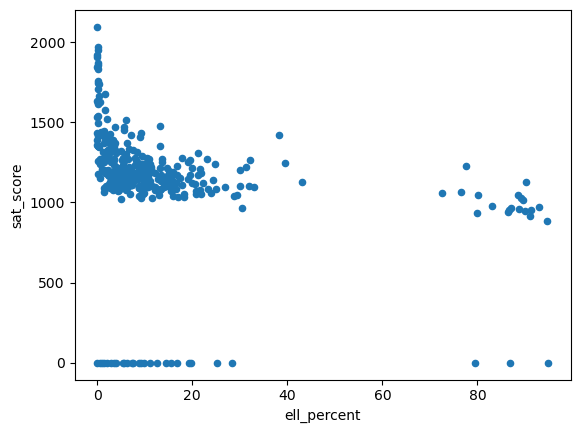

In [ ]:
combined.plot.scatter('ell_percent','sat_score')
plt.show()

One way to make very granular statistics easier to read is to aggregate them. In this case, we aggregate by district, which enables us to understand how ell_percent varies district-by-district instead of the unintelligibly granular school-by-school variation.

### Calculating District-Level Statistics

here we'd find the mean of each column for each unique value in school_dist.

In [39]:
districts = combined.groupby('school_dist').mean(numeric_only=True).reset_index()
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1142.708333,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,987.583333,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1110.285714,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


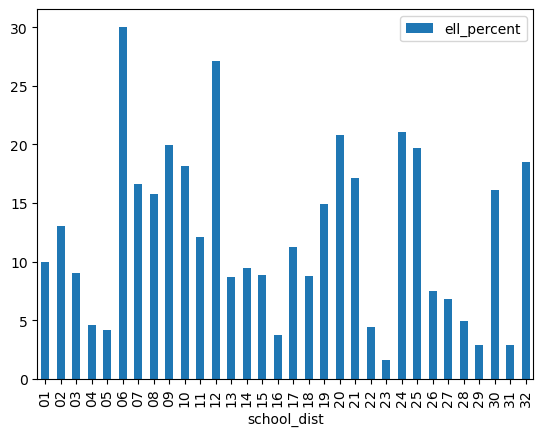

In [62]:
districts.plot.bar('school_dist', 'ell_percent')
plt.show()

### Correlations between Survey fields and sat_score.

<Axes: >

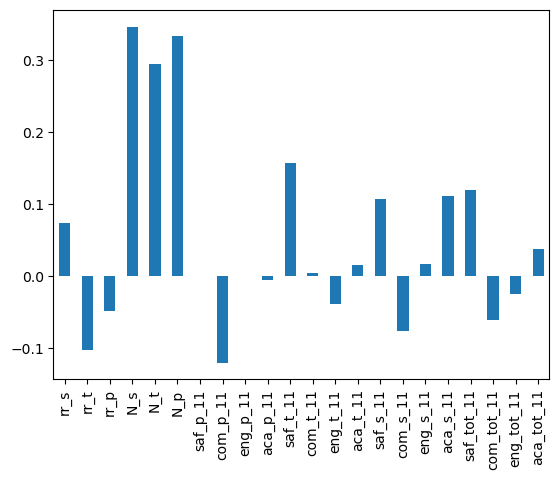

In [43]:
survey_fields =  [ "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
# Correlations between Survey fields and sat_score.
survey_correlations = combined[survey_fields + ['sat_score']].corr(numeric_only=True)['sat_score']
# Plot the correlations and do not display sat_score
survey_correlations = survey_correlations.drop('sat_score')
survey_correlations.plot(kind='bar')


OBservations from plot above:
- There are high correlations between N_s, N_t, N_p, and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.
- It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.
- How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense — it’s difficult to teach or learn in an unsafe environment.
- The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Exploring Safety and SAT Scores

saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score. Let's dig into this relationship a bit more and try to figure out which schools have low safety scores.

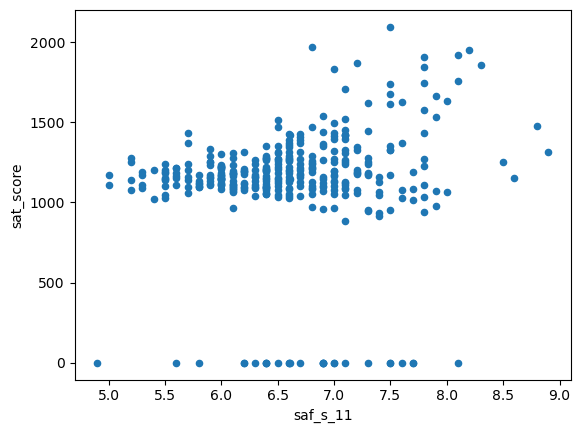

In [44]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn’t very strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

Now, let's compute the average safety score for each borough.

<Axes: xlabel='boro'>

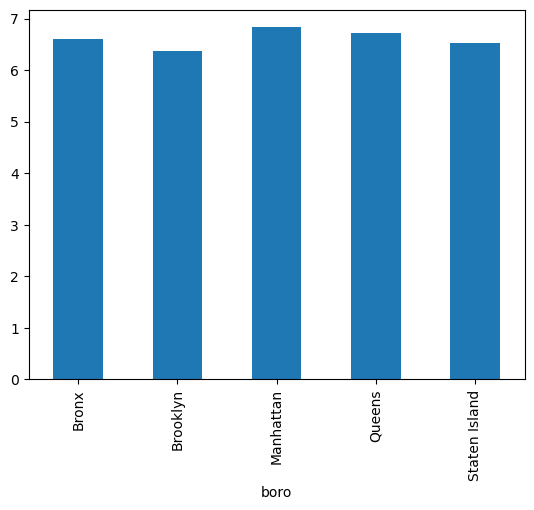

In [48]:
borough_safety = combined.groupby('boro').mean(numeric_only=True)['saf_s_11']
borough_safety.plot(kind='bar')

It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

<Axes: >

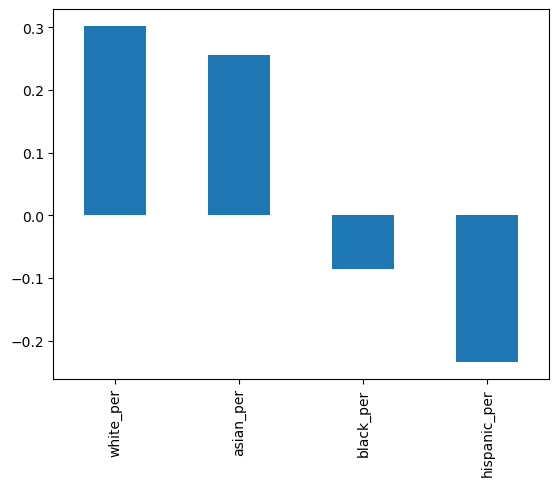

In [49]:
racial_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
racial_correlations = combined[racial_cols + ['sat_score']].corr(numeric_only=True)['sat_score']
racial_correlations = racial_correlations.drop('sat_score')
racial_correlations.plot(kind='bar')

It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.

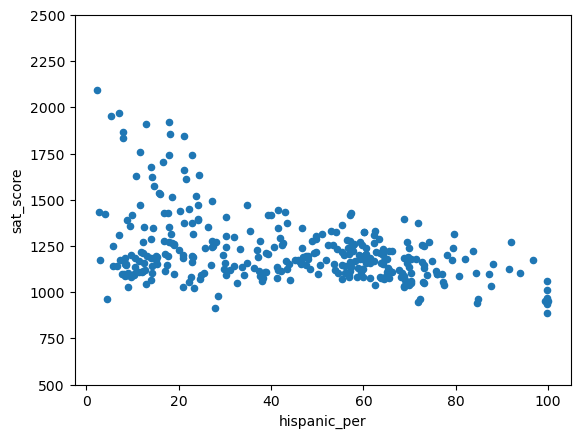

In [52]:
# Make a scatter plot of hispanic_per vs sat_score
combined.plot.scatter('hispanic_per', 'sat_score') 
plt.ylim(500, 2500)
plt.show()

In [53]:
# Schools with hispanic_per greter than 95%
schools_hispanic = combined.query('hispanic_per > 95')['SCHOOL NAME']
print(schools_hispanic.unique())

['MANHATTAN BRIDGES HIGH SCHOOL'
 'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL'
 'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS'
 'ACADEMY FOR LANGUAGE AND TECHNOLOGY'
 'INTERNATIONAL SCHOOL FOR LIBERAL ARTS'
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE'
 'MULTICULTURAL HIGH SCHOOL' 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']


The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [54]:
# Schools with hispanic_per less than 10% and SAT score greater than 1800
schools_hispanic_low = combined.query('hispanic_per < 10 & sat_score > 1800')['SCHOOL NAME']
print(schools_hispanic_low.unique())

['STUYVESANT HIGH SCHOOL' 'BRONX HIGH SCHOOL OF SCIENCE'
 'BROOKLYN TECHNICAL HIGH SCHOOL'
 'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE'
 'STATEN ISLAND TECHNICAL HIGH SCHOOL']


Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn’t explain the low hispanic_per, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

### Gender Differences in SAT Scores

There are two columns that indicate the percentage of each gender at a school:

- male_per
- female_per

We can plot out the correlations between each percentage and sat_score.

<Axes: >

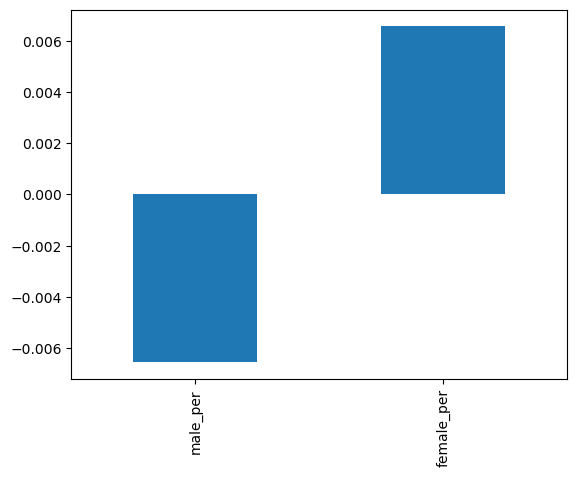

In [55]:
# Plot correations between gender percentages and sat_score
combined[['male_per', 'female_per', 'sat_score']].corr(numeric_only=True)['sat_score'].drop('sat_score').plot(kind='bar')


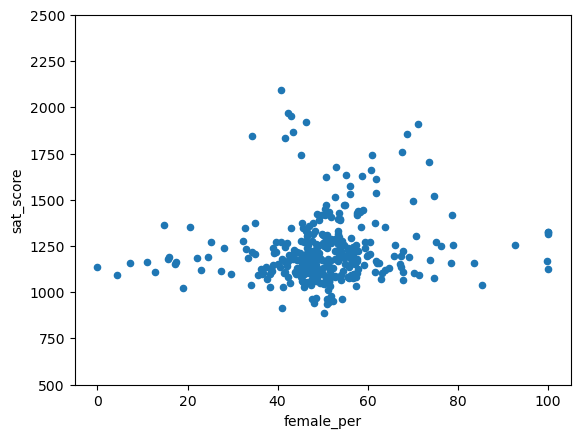

In [56]:
# Make a scatter plot of female_per vs sat_score
combined.plot.scatter('female_per', 'sat_score')
plt.ylim(500, 2500)
plt.show()

Based on the scatter plot, there doesn’t seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [57]:
# Find schools with a female_per greater than 60% and an average SAT score greater than 1700
schools_female_high = combined.query('female_per > 60 & sat_score > 1700')['SCHOOL NAME']
print(schools_female_high.unique())


['BARD HIGH SCHOOL EARLY COLLEGE' 'ELEANOR ROOSEVELT HIGH SCHOOL'
 'BEACON HIGH SCHOOL'
 'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS'
 'TOWNSEND HARRIS HIGH SCHOOL']


These schools appear to be very selective liberal arts schools that have high academic standards.

### Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

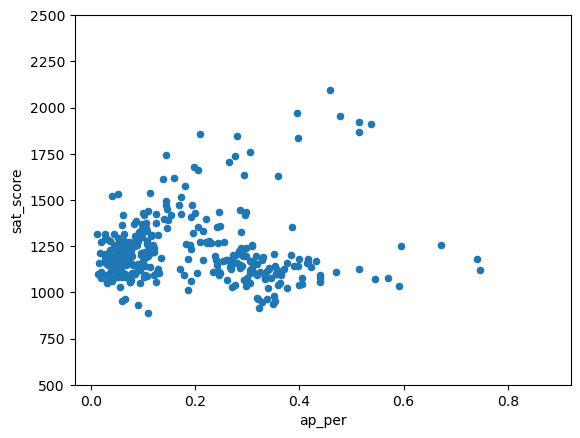

In [58]:
# Calculate the percentage of students who took at least one AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
# Make a scatter plot between ap_per and sat_score
combined.plot.scatter('ap_per', 'sat_score')
plt.ylim(500, 2500)
plt.show()

It looks like there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. It’s not a very strong correlation, however.

## Conclusion
We've done quite a bit of investigation into relationships between demographics and SAT scores. Here are the key observations:

**Enrollment vs SAT Score**   
- SAT score is positively correlated to total_enrollment. But it is mainly where total_enrollment and sat_score are both low.
- There are high correlations between N_s, N_t, N_p, and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

**Survey Response vs SAT Score**   
- rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

**Safety vs SAT Scores**   
- How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense — it’s difficult to teach or learn in an unsafe environment.
- aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards. There are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so. Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

**Race vs SAT Scores**   
- A higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.Many of the schools appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn’t explain the low hispanic_per, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

**Gender vs SAT Scores**  
- There doesn’t seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

**AP Scores vs SAT Scores**   
- There is a positive correlation between the percentage of students in a school who take the AP exam and their average SAT scores. It’s not a very strong correlation, however.


### Author
Puneet Pawar